In [24]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

In [25]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [26]:
def sm_loss(params, samples):

    mu = params["mu"]
    L = params["L"]
    prec = L @ L.T

    centered = samples - mu
    prec2 = prec @ prec
    quad_terms = jnp.sum((centered @ prec2) * centered, axis=1)

    loss = 0.5 * jnp.mean(quad_terms) - jnp.trace(prec)
    
    return loss

In [27]:
def optimize_score_matching_with_tracking(samples, true_mu, true_cov, n_steps=1000, lr=1e-2, seed=0):
    d = samples.shape[1]
    key = jax.random.PRNGKey(seed)
    key_mu, key_L = jax.random.split(key)

    mu_init = jax.random.normal(key_mu, shape=(d,))
    L_init = jnp.eye(d) + 0.01 * jax.random.normal(key_L, shape=(d, d))
    L_init = jnp.tril(L_init)

    params = {"mu": mu_init, "L": L_init}
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    loss_grad_fn = jax.value_and_grad(sm_loss)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }

    for step in range(n_steps):
        loss_val, grads = loss_grad_fn(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        params["L"] = jnp.tril(params["L"])  # keeping L lower-triangular

        # tracking
        mu_hat = params["mu"]
        prec_hat = params["L"] @ params["L"].T
        cov_hat = jnp.linalg.inv(prec_hat)

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_hat))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_hat, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_hat, ord='fro'))

    return params, history


In [28]:
mu = jnp.array([0.0, 1.0, -1.0])

cov = jnp.array([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0]
])

In [29]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

params_hat, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=800, lr=1e-2, seed = 0)

mu_hat = params_hat["mu"]
precision_hat = params_hat["L"] @ params_hat["L"].T
cov_hat = jnp.linalg.inv(precision_hat)

In [30]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(mu_hat, 4), jnp.linalg.norm(mu - mu_hat), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(cov_hat, 4), jnp.linalg.norm(cov - cov_hat), "\n\n\n")

[ 0.  1. -1.] 

 [-0.053   1.0013 -1.003 ] 0.053116128 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[1.0424 0.5286 0.2107]
 [0.5286 1.0222 0.3239]
 [0.2107 0.3239 1.0632]] 0.09638984 





In [31]:
history_np = {k: np.array(v) for k, v in history.items()}

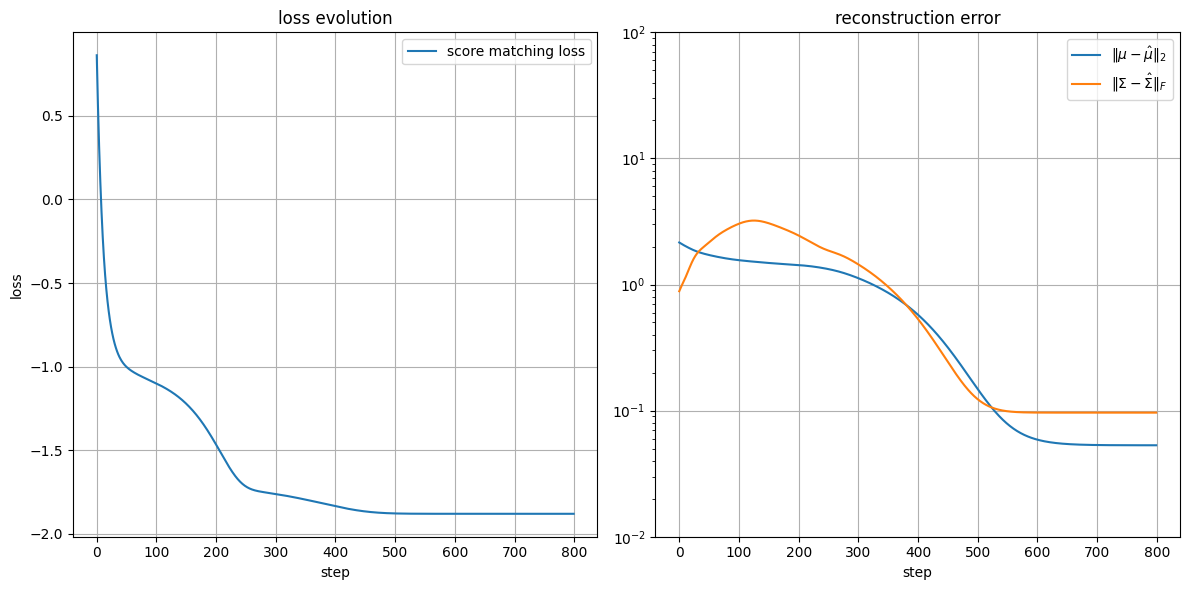

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()


ymin_recon = 1e-2
ymax_recon = 100.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
#plt.plot(history_np["cov_l2"], label=r"$\| \Sigma - \hat{\Sigma} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
history_np["mu_l2"]

array([2.1547, 2.1402, 2.1259, 2.1119, 2.0981, 2.0846, 2.0715, 2.0586,
       2.046 , 2.0337, 2.0216, 2.0097, 1.998 , 1.9865, 1.9752, 1.964 ,
       1.9531, 1.9423, 1.9317, 1.9214, 1.9113, 1.9015, 1.8919, 1.8826,
       1.8736, 1.8649, 1.8564, 1.8482, 1.8403, 1.8326, 1.8252, 1.818 ,
       1.8111, 1.8044, 1.7978, 1.7915, 1.7854, 1.7795, 1.7737, 1.7681,
       1.7626, 1.7573, 1.7521, 1.747 , 1.742 , 1.7371, 1.7323, 1.7276,
       1.723 , 1.7185, 1.714 , 1.7096, 1.7053, 1.7011, 1.6969, 1.6928,
       1.6887, 1.6847, 1.6807, 1.6768, 1.673 , 1.6692, 1.6654, 1.6618,
       1.6581, 1.6545, 1.651 , 1.6475, 1.644 , 1.6406, 1.6373, 1.634 ,
       1.6307, 1.6276, 1.6244, 1.6213, 1.6183, 1.6153, 1.6123, 1.6094,
       1.6066, 1.6038, 1.6011, 1.5984, 1.5957, 1.5931, 1.5906, 1.5881,
       1.5856, 1.5832, 1.5809, 1.5786, 1.5763, 1.5741, 1.5719, 1.5698,
       1.5677, 1.5656, 1.5636, 1.5616, 1.5596, 1.5577, 1.5558, 1.5539,
       1.5521, 1.5503, 1.5485, 1.5467, 1.545 , 1.5432, 1.5415, 1.5398,
      

In [34]:
history_np["cov_fro"]

array([0.8848, 0.9061, 0.9297, 0.9541, 0.9784, 1.0021, 1.0255, 1.049 ,
       1.0733, 1.0986, 1.1254, 1.1537, 1.1835, 1.2148, 1.2474, 1.2812,
       1.3159, 1.3512, 1.387 , 1.4228, 1.4586, 1.4939, 1.5287, 1.5628,
       1.5959, 1.6279, 1.6586, 1.6881, 1.7162, 1.7429, 1.7682, 1.7922,
       1.8151, 1.8369, 1.8578, 1.8779, 1.8974, 1.9164, 1.935 , 1.9535,
       1.9718, 1.9901, 2.0085, 2.027 , 2.0457, 2.0646, 2.0838, 2.1032,
       2.1229, 2.1428, 2.1629, 2.1832, 2.2036, 2.2241, 2.2447, 2.2652,
       2.2858, 2.3062, 2.3266, 2.3469, 2.3671, 2.3872, 2.4071, 2.4269,
       2.4466, 2.466 , 2.4854, 2.5045, 2.5234, 2.5421, 2.5606, 2.5789,
       2.5969, 2.6147, 2.6322, 2.6496, 2.6667, 2.6837, 2.7006, 2.7173,
       2.7339, 2.7504, 2.7669, 2.7832, 2.7994, 2.8156, 2.8316, 2.8474,
       2.8631, 2.8786, 2.8939, 2.9089, 2.9238, 2.9385, 2.9529, 2.9671,
       2.9811, 2.9949, 3.0085, 3.0219, 3.035 , 3.0479, 3.0604, 3.0727,
       3.0846, 3.096 , 3.1071, 3.1177, 3.1278, 3.1374, 3.1465, 3.155 ,
      